In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    return "Done"

set_seed(42)

'Done'

In [3]:
array = np.linspace(0,119,120)
print(array)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119.]


In [4]:
test_size = 20
train_set = array[:-test_size]
test_set = array[-test_size:]

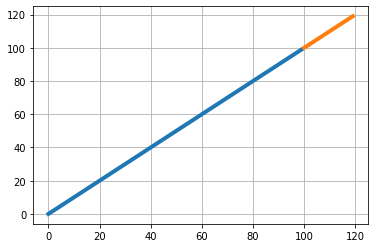

In [5]:
plt.plot(train_set,linewidth=4)
plt.grid(True)
plt.plot(test_set,range(100,120),linewidth=4)

In [6]:
def input_data(data,ws):
    out = []
    
    for i in range(len(data)-ws):
        feature = data[i:i+ws+1]
        out.append(feature)
        
    df = pd.DataFrame(out)
    return df

In [7]:
class CustomDatasetTrain(Dataset):
    def __init__(self):
        self.df = input_data(train_set,3)
        self.x = torch.from_numpy(self.df.drop(3,axis=1).to_numpy()).float()
        self.y = torch.from_numpy(self.df[3].to_numpy()).float()
        self.n_sample = self.df.shape[0]

    def __getitem__(self, index):
        return self.x[index],self.y[index]
    
    def __len__(self):
        return self.n_sample
    
train_data= CustomDatasetTrain()

In [8]:
class CustomDatasetTest(Dataset):
    def __init__(self):
        self.df = input_data(test_set,3)
        self.x = torch.from_numpy(self.df.drop(3,axis=1).to_numpy()).float()
        self.y = torch.from_numpy(self.df[3].to_numpy()).float()
        self.n_sample = self.df.shape[0]

    def __getitem__(self, index):
        return self.x[index],self.y[index]
    
    def __len__(self):
        return self.n_sample
    
test_data = CustomDatasetTest()

In [14]:
batch_size = 5

train_loader = DataLoader(train_data,batch_size)
test_loader = DataLoader(test_data,batch_size)

In [124]:
class GRU(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, linear_output, batch_size, bidirectional, batch_first):
        super().__init__()
        
        self.gru = nn.GRU(input_size = input_size, 
                          hidden_size = hidden_size, 
                          num_layers = num_layers,
                          batch_first= batch_first,
                          bidirectional = bidirectional)
        
        self.linear = nn.Linear(hidden_size,12)
        self.linear_1 = nn.Linear(12,1)
    
    def forward(self,input_data):
        input_ = input_data.reshape(-1,3,1)
        output, hidden = self.gru(input_)
        pred = self.linear(hidden)
        pred = self.linear_1(pred)
        return pred 

In [211]:
model = GRU(input_size = 1,
            hidden_size =100,
            num_layers = 1,
            linear_output = 1,
            batch_size= batch_size,
            bidirectional= False,
            batch_first= True)


loss_func = nn.MSELoss()
optimizer = torch.optim.Adagrad(model.parameters(),lr=0.1)

In [212]:
print(model)

GRU(
  (gru): GRU(1, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=12, bias=True)
  (linear_1): Linear(in_features=12, out_features=1, bias=True)
)


In [213]:
epochs = 200
loss = 0

for epoch in range(epochs):
    for data,label in train_loader:
        optimizer.zero_grad()
        
        pred = model.forward(data)
        loss = loss_func(pred,label.reshape(1,-1,1))
        loss.backward()
        
        optimizer.step()
    print(loss.item())

8.358963966369629
27.355655670166016
32.170440673828125
46.75532913208008
11.89326286315918
10.926894187927246
57.55889129638672
24.86859893798828
1.6075060367584229
9.08100700378418
20.221107482910156
12.09842300415039
2.9582228660583496
21.744216918945312
0.12303908914327621
6.754521369934082
0.1741228848695755
0.7165827751159668
2.969858407974243
8.666732788085938
13.001710891723633
2.740452289581299
0.2762361764907837
12.484188079833984
4.519959449768066
2.0541563034057617
7.439686298370361
2.8831379413604736
8.621054649353027
11.886907577514648
3.2952213287353516
0.3184678852558136
2.732790946960449
1.8779836893081665
0.6425650715827942
15.629262924194336
13.66583251953125
4.328098773956299
5.399316787719727
6.26401424407959
0.6301209330558777
0.5305061340332031
0.2785472571849823
13.078117370605469
23.144073486328125
5.031002044677734
4.578484535217285
3.9692578315734863
3.0968496799468994
1.0408354997634888
0.178994283080101
0.8543654084205627
0.11275139451026917
0.5950565934181

In [214]:
model.eval()
loss = 0
batch = 0
original = []
predi = []
with torch.no_grad():
    for data, label in test_loader:
        pred = model.forward(data)
        original.extend(label.tolist())
        predi.extend(pred[0].reshape(1,-1).tolist())
        loss += loss_func(pred,label.reshape(1,-1,1))
        print(label,pred)
        batch+=1
        
    print(f"Loss : {loss/batch}")

tensor([103., 104., 105., 106., 107.]) tensor([[[100.2203],
         [100.5615],
         [100.9048],
         [101.2533],
         [101.6091]]])
tensor([108., 109., 110., 111., 112.]) tensor([[[101.9728],
         [102.3439],
         [102.7210],
         [103.1019],
         [103.4836]]])
tensor([113., 114., 115., 116., 117.]) tensor([[[103.8631],
         [104.2369],
         [104.6021],
         [104.9557],
         [105.2957]]])
tensor([118., 119.]) tensor([[[105.6202],
         [105.9282]]])
Loss : 85.63278198242188


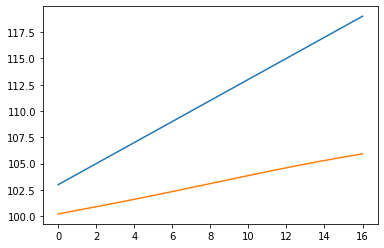

In [215]:
test = []
for i in predi:
    test.extend(i)

#test = [int(i) for i in test]
plt.plot(original)
plt.plot(test)